In [2]:
import pandas as pd
import os
import chardet
from multiprocessing import Pool
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr, pearsonr
import gensim

sns.set_theme(style="whitegrid")

In [3]:
GENERATE_DATA = True

In [4]:
dirs = [
    "data/counts",
    "data/final",
    "results",
]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

# Word frequencies

## Chinese

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0010729

In [5]:
if GENERATE_DATA and not os.path.exists("data/counts/chinese.csv"):
    chinese_frequencies_filename = "data/raw/SUBTLEX-CH-WF"

    alternative_encodings = ["GB18030", "UTF-8", "ISO-8859-1"]
    for enc in alternative_encodings:
        try:
            df = pd.read_csv(chinese_frequencies_filename, encoding=enc, sep="\t")
            print(f"Successfully read with encoding {enc}")
            break
        except UnicodeDecodeError as e:
            print(f"Error with encoding {enc}: {e}")

    df_chinese_frequencies = pd.read_csv(
        chinese_frequencies_filename, encoding=enc, sep="\t"
    )
    df_chinese_frequencies = df_chinese_frequencies.rename(
        columns={"Word": "word", "WCount": "count"}
    )

    df_chinese_frequencies = df_chinese_frequencies[["word", "count"]]

    df_chinese_frequencies.to_csv("data/counts/chinese.csv", index=False)

## Spanish


In [6]:
def process_file(file):
    with open(file, "rb") as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        encoding = result["encoding"]

        try:
            content = raw_data.decode(encoding)
        except UnicodeDecodeError:
            content = raw_data.decode(encoding, errors="replace")

    vectorizer = CountVectorizer()
    spanish_counts = vectorizer.fit_transform([content])
    spanish_words = vectorizer.get_feature_names_out()
    word_counts = spanish_counts.toarray()[0]

    return {word: count for word, count in zip(spanish_words, word_counts)}


if GENERATE_DATA and not os.path.exists("data/counts/spanish.csv"):
    directory = "data/raw/spanish_corpus"
    files = [os.path.join(directory, file) for file in os.listdir(directory)]

    with Pool() as pool:
        with tqdm(total=len(files), desc="Processing files") as pbar:
            word_counts_list = []
            for result in pool.imap_unordered(process_file, files):
                word_counts_list.append(result)
                pbar.update(1)

    # Combine word counts from all files
    combined_word_counts = {}
    for word_counts in word_counts_list:
        for word, count in word_counts.items():
            combined_word_counts[word] = combined_word_counts.get(word, 0) + count

    word_counts_df = pd.DataFrame(
        combined_word_counts.items(), columns=["word", "count"]
    )
    word_counts_df = word_counts_df[["word", "count"]]
    word_counts_df.to_csv("data/counts/spanish.csv", index=False)

## English

In [7]:
if GENERATE_DATA and not os.path.exists("data/counts/english.csv"):
    df_eng_counts = pd.read_csv("data/raw/unigram_freq.csv")
    df_eng_counts.to_csv("data/counts/english.csv", index=False)

# Collating embeddings and word frequencies

## Gensim embeddings

To compare Word2Vec, fastText, and GloVe, holding the language and source as constant (English and Gensim). 

In [8]:
gensim_dict = {
    "word2vec": "word2vec-google-news-300",
    "fasttext": "fasttext-wiki-news-subwords-300",
    "glove": "glove-wiki-gigaword-300",
}

# Load the english counts
df_eng_counts = pd.read_csv("data/counts/english.csv")

for modelname, modelkey in gensim_dict.items():
    output_name = f"data/final/gensim-{modelname}.csv"
    if os.path.exists(output_name):
        continue

    model = gensim.downloader.load(modelkey)
    words = model.index_to_key
    vectors = model.vectors
    magnitudes = (vectors**2).sum(axis=1) ** 0.5

    # Create a df with the words and magnitudes
    df_magnitudes = pd.DataFrame({"word": words, "magnitude": magnitudes})

    # Merge with the english counts
    df_merged = pd.merge(df_eng_counts, df_magnitudes, on="word", how="inner")

    # Calculate frequency and ranks
    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    # Save the merged df
    df_merged.to_csv(output_name, index=False)

## fastText embeddings 

To compare word embeddings across English, Spanish, and Chinese, holding the emebedding model as constant. 

In [9]:
def read_fasttext_embeddings(file_path):
    words = []
    magnitudes = []

    with open(file_path, "r", encoding="utf-8") as f:
        # Skip the header line
        next(f)

        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            vector = np.array(parts[1:], dtype=float)
            magnitude = np.linalg.norm(vector)

            words.append(word)
            magnitudes.append(magnitude)

    return pd.DataFrame({"word": words, "magnitude": magnitudes})

In [10]:
fasttext_dict = {
    "english": "data/raw/wiki.en.vec",
    "spanish": "data/raw/wiki.es.vec",
    "chinese": "data/raw/wiki.zh.vec",
}

for language, path in fasttext_dict.items():
    output_name = f"data/final/fasttext-{language}.csv"

    if os.path.exists(output_name):
        continue

    df_counts = pd.read_csv(f"data/counts/{language}.csv")
    df_mags = read_fasttext_embeddings(path)
    df_merged = pd.merge(df_counts, df_mags, on="word", how="inner")

    df_merged["frequency"] = df_merged["count"] / df_merged["count"].sum()
    df_merged["frequency_rank"] = df_merged["frequency"].rank(ascending=False)
    df_merged["magnitude_rank"] = df_merged["magnitude"].rank(ascending=False)

    df_merged.to_csv(output_name, index=False)

# Experiments

## Confirming Zipf's Law

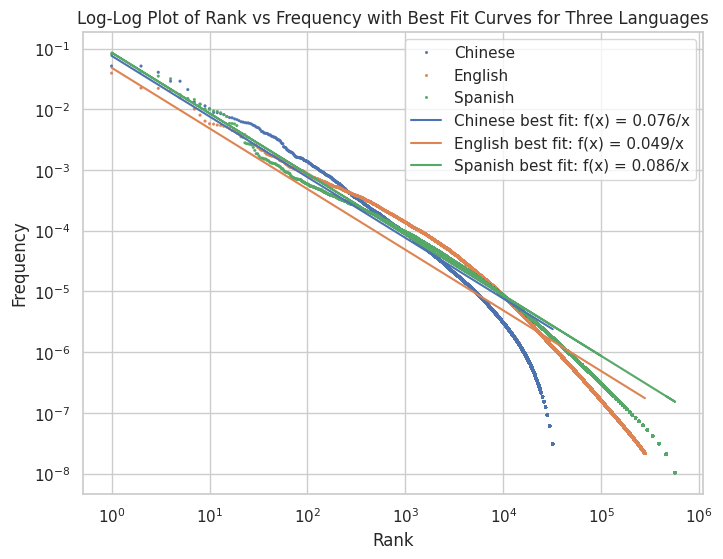

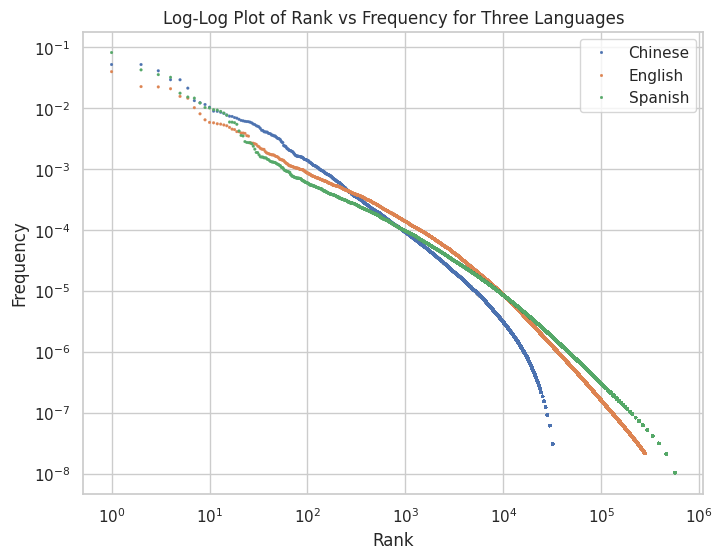

In [11]:
# Define the new power law function with only parameter c
def power_law(x, c):
    return c / x


# Function to load data, fit the curve, and return the necessary data
def process_language_data(file_path, language):
    df = pd.read_csv(file_path)
    df["rank"] = df["frequency_rank"]
    df["frequency"] = df["frequency"]
    df["language"] = language

    x_data = df["rank"].values
    y_data = df["frequency"].values

    # Fit the curve with the new function
    params, _ = curve_fit(power_law, x_data, y_data)
    c_best_fit = params[0]

    df["c_best_fit"] = c_best_fit

    return df


# Load data for each language
languages = ["Chinese", "English", "Spanish"]
file_paths = [
    "data/final/fasttext-chinese.csv",
    "data/final/fasttext-english.csv",
    "data/final/fasttext-spanish.csv",
]
dataframes = [
    process_language_data(file, lang) for lang, file in zip(languages, file_paths)
]

# Concatenate all dataframes
df_all = pd.concat(dataframes)

for t in [True, False]:
    # Plot the data and the best fit curves using seaborn
    plt.figure(figsize=(8, 6))

    # Scatter plot
    sns.scatterplot(
        data=df_all,
        x="rank",
        y="frequency",
        hue="language",
        s=4,
        edgecolor=None,
    )

    if t:
        # Plot the best fit curves
        for lang, group_df in df_all.groupby("language"):
            x_data = group_df["rank"].values
            c_best_fit = group_df["c_best_fit"].values[0]
            plt.plot(
                x_data,
                power_law(x_data, c_best_fit),
                label=f"{lang} best fit: f(x) = {c_best_fit:.3f}/x",
            )
    title = (
        "Log-Log Plot of Rank vs Frequency with Best Fit Curves for Three Languages"
        if t
        else "Log-Log Plot of Rank vs Frequency for Three Languages"
    )

    plt.ylabel("Frequency")
    plt.xlabel("Rank")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.legend()
    plt.show()

## Word embedding magnitude as a function of word frequency 

In [ ]:
experiments = {
    "gensim": ["word2vec", "fasttext", "glove"],
    "fasttext": ["chinese", "english", "spanish"],
}

start_value = 10
ratio = 10 ** (1 / 10)
num_values = 46

top_n_values = [int(start_value * (ratio**i)) for i in range(num_values)]

for experiment, models in experiments.items():
    correlations = []
    for model in models:
        for top_n in top_n_values:
            df_model = pd.read_csv(f"data/final/{experiment}-{model}.csv")
            df_model = df_model.sort_values("frequency_rank").head(top_n)

            # Calculate the correlation coefficients
            spearman_corr, _ = spearmanr(
                df_model["magnitude_rank"], df_model["frequency_rank"]
            )
            pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

            correlations.append(
                {
                    "Top N Values": top_n,
                    "Correlation Coefficient": spearman_corr,
                    "Correlation Measure": "Spearman's rank correlation coefficient",
                    "Model": model.split("-")[0],
                }
            )
            correlations.append(
                {
                    "Top N Values": top_n,
                    "Correlation Coefficient": pearson_corr,
                    "Correlation Measure": "Pearson's correlation coefficient",
                    "Model": model.split("-")[0],
                }
            )

    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=pd.DataFrame(correlations),
        x="Top N Values",
        y="Correlation Coefficient",
        hue="Model",
        style="Correlation Measure",
        markers=True,
        dashes=False,
    )
    plt.xscale("log")
    plt.xlabel("Top N Values")
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Correlation Coefficients vs Top N Values: {experiment} experiments")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Correlations: varying models and top n words

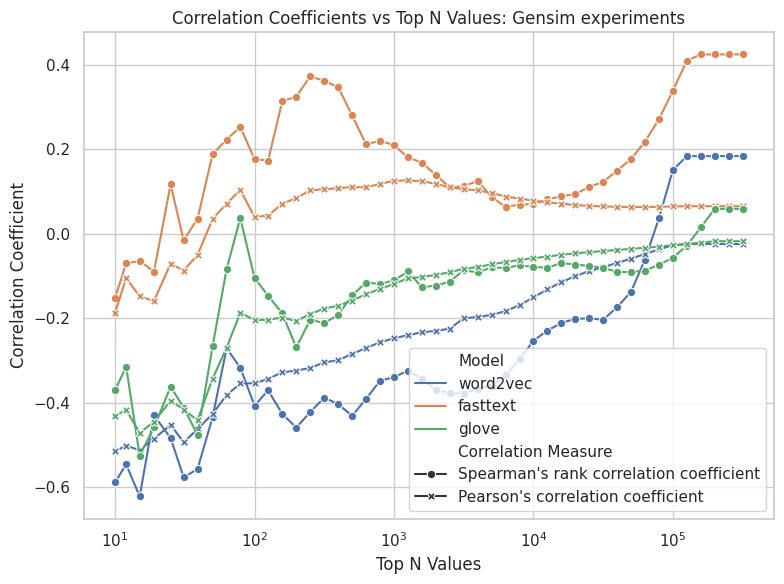

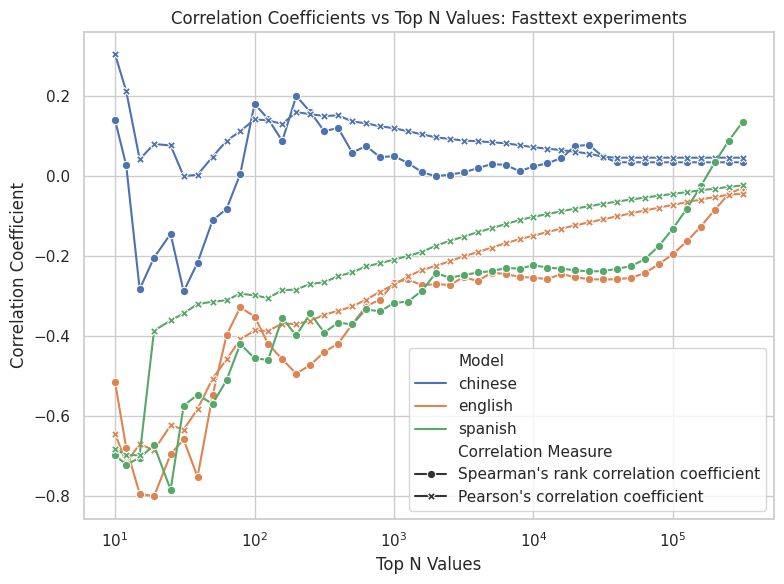

In [12]:
experiments = {
    "gensim": ["word2vec", "fasttext", "glove"],
    "fasttext": ["chinese", "english", "spanish"],
}

start_value = 10
ratio = 10 ** (1 / 10)
num_values = 46

top_n_values = [int(start_value * (ratio**i)) for i in range(num_values)]

for experiment, models in experiments.items():
    correlations = []
    for model in models:
        for top_n in top_n_values:
            df_model = pd.read_csv(f"data/final/{experiment}-{model}.csv")
            df_model = df_model.sort_values("frequency_rank").head(top_n)

            # Calculate the correlation coefficients
            spearman_corr, _ = spearmanr(
                df_model["magnitude_rank"], df_model["frequency_rank"]
            )
            pearson_corr, _ = pearsonr(df_model["magnitude"], df_model["frequency"])

            correlations.append(
                {
                    "Top N Values": top_n,
                    "Correlation Coefficient": spearman_corr,
                    "Correlation Measure": "Spearman's rank correlation coefficient",
                    "Model": model.split("-")[0],
                }
            )
            correlations.append(
                {
                    "Top N Values": top_n,
                    "Correlation Coefficient": pearson_corr,
                    "Correlation Measure": "Pearson's correlation coefficient",
                    "Model": model.split("-")[0],
                }
            )

    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=pd.DataFrame(correlations),
        x="Top N Values",
        y="Correlation Coefficient",
        hue="Model",
        style="Correlation Measure",
        markers=True,
        dashes=False,
    )
    plt.xscale("log")
    plt.xlabel("Top N Values")
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Correlation Coefficients vs Top N Values: {experiment} experiments")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()